In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
%cd /content/drive/MyDrive/MS983/Datasets/LIAR/

import pandas as pd
import numpy as np
import tensorflow as tf
from huggingface_hub import hf_hub_download
from transformers import BertTokenizerFast
import shap
import matplotlib.pyplot as plt

# Load LIAR
df = pd.read_csv("liar_dataset.csv")[["statement", "label_binary", "dataset"]].dropna()
texts = df["statement"].tolist()
labels = df["label_binary"].values
dataset = df["dataset"].values

# Only test set
test_idx = dataset == 2
test_texts = [texts[i] for i in np.where(test_idx)[0]]

# Tokenizer + model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
MODEL_PATH = hf_hub_download("euansmith9/liar_bert_model", "liar_bert.keras")
model = tf.keras.models.load_model(MODEL_PATH)


/content/drive/MyDrive/MS983/Datasets/LIAR


/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Prediction function
def f(x):
    enc = tokenizer(
        list(x),
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="np"
    )
    inputs = {
        "token_ids": enc["input_ids"],
        "padding_mask": enc["attention_mask"],
        "segment_ids": np.zeros_like(enc["input_ids"]),
    }
    logits = model.predict(inputs, verbose=0).squeeze()
    probs_real = tf.sigmoid(logits).numpy().ravel()
    return np.stack([1 - probs_real, probs_real], axis=-1) 


In [36]:
# Pick a subset of 200 test samples at random for speed
np.random.seed(42)
subset_idx = np.random.choice(len(test_texts), size=200, replace=False)
sample_texts = [test_texts[i] for i in subset_idx]

explainer = shap.Explainer(f, tokenizer)
shap_values = explainer(sample_texts)

  0%|          | 0/30 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 23/200 [00:57<06:46,  2.30s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 201it [06:57,  2.09s/it]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setup lists to collect data
all_tokens = []
all_fake = []
all_real = []

# Extract tokens and SHAP values
for sv in shap_values:
    tokens = sv.data
    vals = sv.values  

    all_tokens.extend(tokens)
    all_fake.extend(vals[:, 0])  # contributions to "fake"
    all_real.extend(vals[:, 1])  # contributions to "real"

# Put into DataFrame for grouping
df_shap = pd.DataFrame({
    "token": all_tokens,
    "fake": all_fake,
    "real": all_real
})

# Compute mean signed SHAP values per token
mean_fake = df_shap.groupby("token")["fake"].mean().sort_values(ascending=False).head(20)
mean_real = df_shap.groupby("token")["real"].mean().sort_values(ascending=False).head(20)


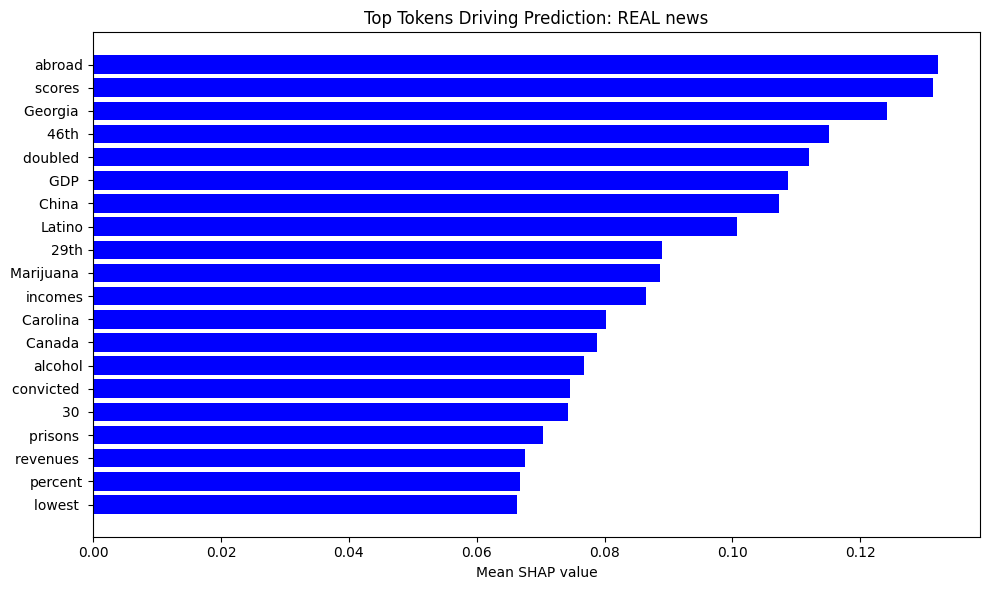

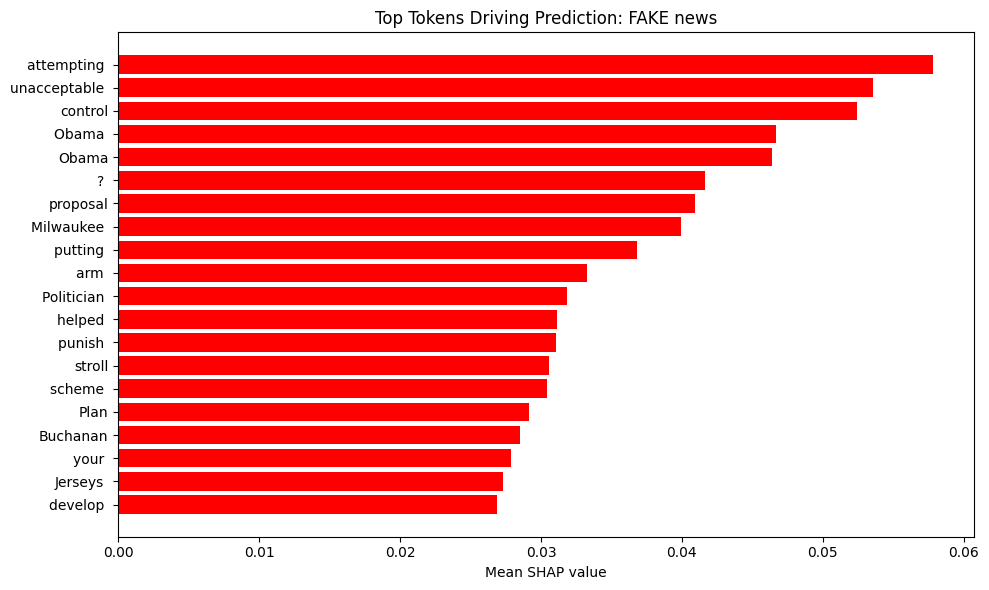

In [ ]:
# Plot top tokens for each class
plt.figure(figsize=(10,6))
plt.barh(mean_real.index[::-1], mean_real.values[::-1], color="blue")
plt.title("Top Tokens Driving Prediction: REAL news")
plt.xlabel("Mean SHAP value")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.barh(mean_fake.index[::-1], mean_fake.values[::-1], color="red")
plt.title("Top Tokens Driving Prediction: FAKE news")
plt.xlabel("Mean SHAP value")
plt.tight_layout()
plt.show()